# CONSENSUS ANALYSIS OF CASSETTES

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading clustering files
cassettes_r60 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res60_cassettes.csv", index_col=0)
cassettes_r140 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res140_cassettes.csv", index_col=0)
cassettes_r120 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res120_cassettes.csv", index_col=0)
cassettes_r140 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res140_cassettes.csv", index_col=0)

In [7]:
# Reading top variance cpgs to show
top_5000_cpgs = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_top_var_5000.txt", header=None)
top_10000_cpgs = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_top_var_10000.txt", header=None)
top_30000_cpgs = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_top_var_30000.txt", header=None)

In [8]:
# Step 1: Convert to list
cpg_list = top_10000_cpgs.iloc[:, 0].to_list()

# Step 2: Filter to those in index of cassettes_r140
filtered_cpgs = [cpg for cpg in cpg_list if cpg in cassettes_r140.index]

In [9]:
cassettes_r140 = cassettes_r140.loc[filtered_cpgs,]

In [ ]:
# WITHOUT NORMALIZATION

# Step 1: Setup
ids = list(cassettes_r140.index)  # CpG identifiers
n = len(ids)  # Number of CpGs
id_to_idx = dict(zip(ids, range(n)))  # Map CpG labels to matrix indices

# This will store co-clustering counts only (no normalizing)
pair_counts = defaultdict(int)

# Step 2: Iterate through each clustering result (each column in DataFrame)
for col in cassettes_r140.columns:

    clustering = cassettes_r140[col].dropna()  # Drop NaN values (CpGs not present in this clustering)
    
    # List of CpGs in this clustering run (after dropping NaNs)
    present_ids = clustering.index.tolist()  # The CpGs present in this clustering

    # Step 3: Count co-clustered CpGs
    for i in range(len(present_ids)):
        for j in range(i + 1, len(present_ids)):
            id1, id2 = present_ids[i], present_ids[j]
            idx1, idx2 = id_to_idx[id1], id_to_idx[id2]

            if clustering[id1] == clustering[id2]:
                pair_counts[(idx1, idx2)] += 1
                pair_counts[(idx2, idx1)] += 1

# Step 4: Build COO sparse matrix from counts
row_idx = []
col_idx = []
data = []

for (i, j), count in pair_counts.items():
    row_idx.append(i)
    col_idx.append(j)
    data.append(count)

consensus_matrix = coo_matrix((data, (row_idx, col_idx)), shape=(n, n))
print(consensus_matrix)

KeyboardInterrupt: 

/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


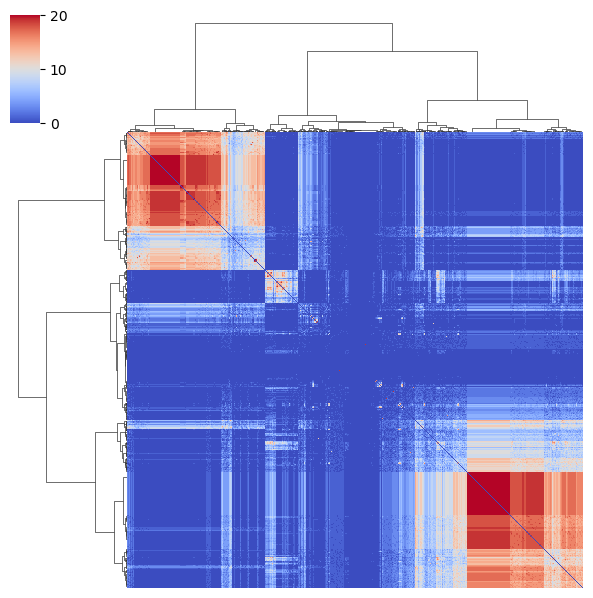

In [90]:
# Convert to dense array for plotting
consensus_matrix_dense = consensus_matrix.toarray()

sns.clustermap(consensus_matrix_dense, 
               cmap="coolwarm", 
               method="ward", 
               metric="euclidean", 
               figsize=(6, 6),
               xticklabels=False, yticklabels=False
               )
plt.show()

In [10]:
# WITH NORMALIZATION

# Step 1: Setup
ids = list(cassettes_r140.index)
n = len(ids)
id_to_idx = dict(zip(ids, range(n)))

pair_counts = defaultdict(int)
pair_total = defaultdict(int)  # Count of times both CpGs were present

# Step 2: Iterate through each clustering result
for col in cassettes_r140.columns:
    clustering = cassettes_r140[col].dropna()
    present_ids = clustering.index.tolist()
    
    for i in range(len(present_ids)):
        for j in range(i + 1, len(present_ids)):
            id1, id2 = present_ids[i], present_ids[j]
            idx1, idx2 = id_to_idx[id1], id_to_idx[id2]
            
            pair_total[(idx1, idx2)] += 1
            pair_total[(idx2, idx1)] += 1
            
            if clustering[id1] == clustering[id2]:
                pair_counts[(idx1, idx2)] += 1
                pair_counts[(idx2, idx1)] += 1

# Step 4: Build normalized COO sparse matrix
row_idx = []
col_idx = []
data = []

for (i, j), count in pair_counts.items():
    total = pair_total[(i, j)]
    if total > 0:
        row_idx.append(i)
        col_idx.append(j)
        data.append(count / total)  # Normalize

consensus_matrix = coo_matrix((data, (row_idx, col_idx)), shape=(n, n))
print(consensus_matrix)


<COOrdinate sparse matrix of dtype 'float64'
	with 47335258 stored elements and shape (10000, 10000)>
  Coords	Values
  (1, 3)	1.0
  (3, 1)	1.0
  (1, 5)	0.15
  (5, 1)	0.15
  (1, 9)	1.0
  (9, 1)	1.0
  (1, 11)	1.0
  (11, 1)	1.0
  (1, 12)	1.0
  (12, 1)	1.0
  (1, 17)	1.0
  (17, 1)	1.0
  (1, 20)	1.0
  (20, 1)	1.0
  (1, 22)	1.0
  (22, 1)	1.0
  (1, 23)	0.95
  (23, 1)	0.95
  (1, 24)	0.5
  (24, 1)	0.5
  (1, 25)	1.0
  (25, 1)	1.0
  (1, 27)	1.0
  (27, 1)	1.0
  (1, 28)	1.0
  :	:
  (9977, 9967)	0.05
  (9970, 9975)	0.05
  (9975, 9970)	0.05
  (9970, 9977)	0.05
  (9977, 9970)	0.05
  (9970, 9980)	0.05
  (9980, 9970)	0.05
  (9970, 9982)	0.05
  (9982, 9970)	0.05
  (9970, 9985)	0.05
  (9985, 9970)	0.05
  (9970, 9989)	0.05
  (9989, 9970)	0.05
  (9972, 9975)	0.05
  (9975, 9972)	0.05
  (9972, 9977)	0.05
  (9977, 9972)	0.05
  (9972, 9980)	0.05
  (9980, 9972)	0.05
  (9972, 9982)	0.05
  (9982, 9972)	0.05
  (9972, 9985)	0.05
  (9985, 9972)	0.05
  (9972, 9989)	0.05
  (9989, 9972)	0.05


/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


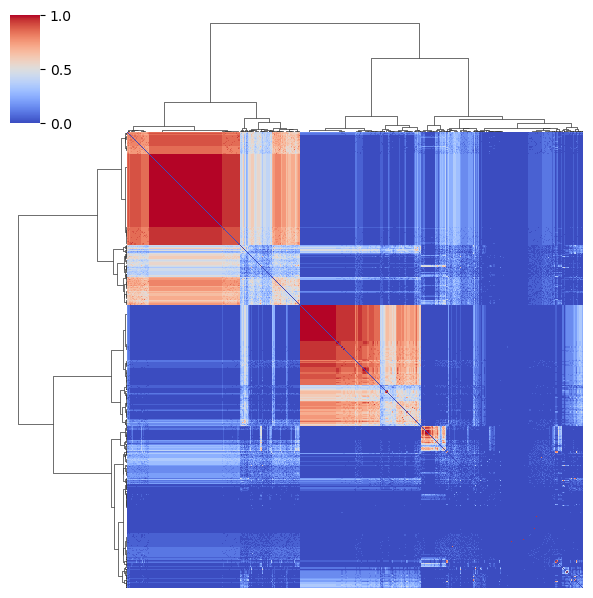

In [11]:
# Convert to dense array for plotting
consensus_matrix_dense = consensus_matrix.toarray()

sns.clustermap(consensus_matrix_dense, 
               cmap="coolwarm", 
               method="ward", 
               metric="euclidean", 
               figsize=(6, 6),
               xticklabels=False, yticklabels=False
               )
plt.show()

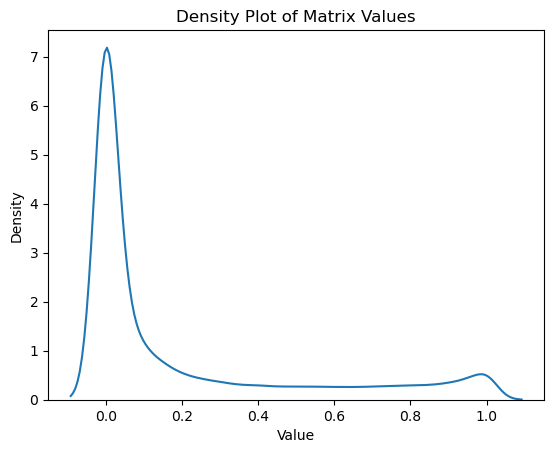

In [12]:
# Flatten the consensus matrix to 1D
values = consensus_matrix_dense.flatten()

# Plot density plot
sns.kdeplot(values, bw_adjust=4)  
plt.title("Density Plot of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()